# Fingerprint on Paintings

<font size = 4>
In this file we will
* show the structure of the trained net
* show the learning curve to give a clue to the training process
* classify a test image
* visualize the net
</font>

## 1. Setup

In [13]:
#import numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline
import caffe

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

## 2. Configure PATH
Modify the PATH for your own net

In [2]:
#config PATH
PROJ_ROOT = './'     #This is the the root of Fingerprint on Paintings Project
MODEL_FILE = PROJ_ROOT + 'deploy.prototxt'
WEIGHTS_FILE = PROJ_ROOT + 'model/fingerprint_style_caffenet.caffemodel'
TEST_FILE = PROJ_ROOT + 'data/test.txt'
LABELS_FILE = PROJ_ROOT + 'data/style_labels.txt'
MEAN_FILE = PROJ_ROOT + 'ilsvrc_2012_mean.npy'

## 3. Load the trained net
Set gpu mode as you like.

In [3]:
## load a trained caffemodel
#caffe.set_mode_gpu()
net = caffe.Net(MODEL_FILE,      # defines the structure of the model
                WEIGHTS_FILE,  # contains the trained weights
                caffe.TEST)   # use test mode (e.g., don't perform dropout)   

## 4. Net structure
### Visulization of the net.

In [24]:
#Net image
#TODO yingzhi


### Layers' activation shapes: each layer's neuron shapes with (batch_size, channel_dim, height, width)

In [22]:
#Layers' activation shapes: each layer's neuron shapes(num of neurons = multiplying elements of the vector))
#with (batch_size, channel_dim, height, width)
for layer_name, blob in net.blobs.iteritems():
    print layer_name + '\t' + str(blob.data.shape)

data	(50L, 3L, 227L, 227L)
conv1	(50L, 96L, 55L, 55L)
pool1	(50L, 96L, 27L, 27L)
norm1	(50L, 96L, 27L, 27L)
conv2	(50L, 256L, 27L, 27L)
pool2	(50L, 256L, 13L, 13L)
norm2	(50L, 256L, 13L, 13L)
conv3	(50L, 384L, 13L, 13L)
conv4	(50L, 384L, 13L, 13L)
conv5	(50L, 256L, 13L, 13L)
pool5	(50L, 256L, 6L, 6L)
fc6	(50L, 4096L)
fc7	(50L, 4096L)
fc8_fingerprint	(50L, 140L)
prob	(50L, 140L)


### Layers' parameter shapes: convolution kernel/filter shapes with (output_channels, input_channels, filter_height, filter_width) and the 1-dimensional shape (output_channels,)

In [23]:
#Layers' parameter shapes: convolution kernel/filter shapes(num of parameters = multiplying elements of the vector, and num of filters = output_channels*input_channels)
#with (output_channels, input_channels, filter_height, filter_width) and the 1-dimensional shape (output_channels,)
for layer_name, param in net.params.iteritems():
    print layer_name + '\t' + str(param[0].data.shape), str(param[1].data.shape)   #[0] for weights and [1] for biases

conv1	(96L, 3L, 11L, 11L) (96L,)
conv2	(256L, 48L, 5L, 5L) (256L,)
conv3	(384L, 256L, 3L, 3L) (384L,)
conv4	(384L, 192L, 3L, 3L) (384L,)
conv5	(256L, 192L, 3L, 3L) (256L,)
fc6	(4096L, 9216L) (4096L,)
fc7	(4096L, 4096L) (4096L,)
fc8_fingerprint	(140L, 4096L) (140L,)


## 5. Learning curve

In [5]:
#TODO yingzhi
#refer to plot_traing_log.py.example
#python parse_log.py log_file out_dir can parse train and test loss and acc into files

## 6. Cassificaiton
### Load testset and labels
Set the size of the input if conducting batching.

In [7]:
#Load testset(image links and label number)
testset = np.loadtxt(TEST_FILE, str, delimiter=' ')
#Load labels(label number and label) so as to output labels
#labels = np.loadtxt(LABELS_FILE, str, delimiter='\t')
labels = {}
for line in open(LABELS_FILE, 'r'):
    key, label = line.decode('utf-8').rstrip('\n\r').split('\t')
    labels[key] = label
# set the size of the input(different batchsize can be set for batching)
net.blobs['data'].reshape(50,        # batch size
                          3,         # 3-channel (BGR) images
                          227, 227)  # image size is 227x227

### Define image transformer
Training images input to the net are transformed by caffe to fit the net defined in MODEL_FILE like  
> transform_param {  
    　　mirror: false  
    　　crop_size: 227  
    　　mean_file: "imagenet_mean.binaryproto" 

So we first define image transformer.

In [8]:
# load the mean ImageNet image (as distributed with Caffe) for subtraction
mu = np.load(MEAN_FILE)
mu = mu.mean(1).mean(1)  # average over pixels to obtain the mean (BGR) pixel values
print 'mean-subtracted values:', zip('BGR', mu)

# create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR

mean-subtracted values: [('B', 104.0069879317889), ('G', 116.66876761696767), ('R', 122.6789143406786)]


### Load image and label
#### Load and transform image

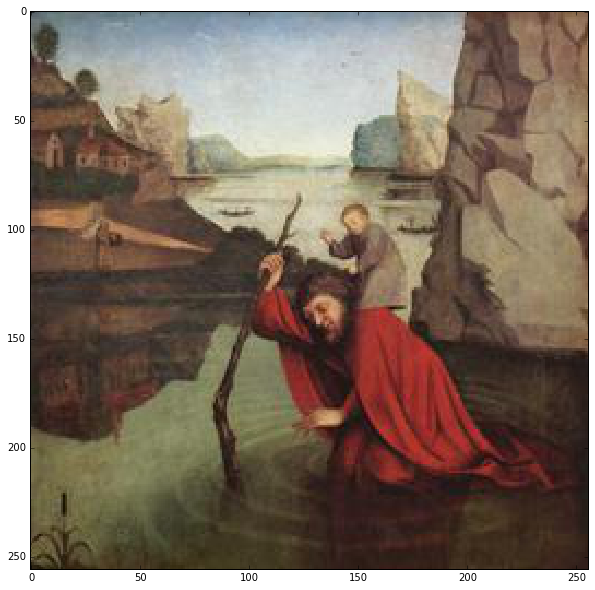

In [29]:
#Load one image from testset
image = caffe.io.load_image(testset[0][0])
plt.imshow(image)
#Transform
transformed_image = transformer.preprocess('data', image)

#### Print correct label

In [30]:
# print correct label
correct_label = labels[str(testset[0][1])]
print 'Correct label is: ' + correct_label

Correct label is: Northern Renaissance


### Predict the image
 Predicted category and a vector of probabilities are provided.

In [32]:
# copy the image data into the memory allocated for the net
net.blobs['data'].data[...] = transformed_image
# perform classification
output = net.forward()
output_prob = output['prob'][0]  # the output probability vector for the first image in the batch
# sort top five predictions from softmax output
top_inds = output_prob.argsort()[::-1][:5]  # reverse sort and take five largest items
print 'Predicted category is', labels[str(output_prob.argmax())]
print 'with labels and probabilities:'
for ind in top_inds:
    print labels[str(ind)] + ': ' + str(output_prob[ind])

Predicted category is Northern Renaissance
with labels and probabilities:
Northern Renaissance: 0.981293
High Renaissance: 0.00817831
Neoclassicism: 0.00469625
Romanticism: 0.0016655
Rococo: 0.00119518


## 7. Visualization of the net


In [11]:
#define a func for visualizing sets of rectangular heatmaps.
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())  
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data); plt.axis('off')

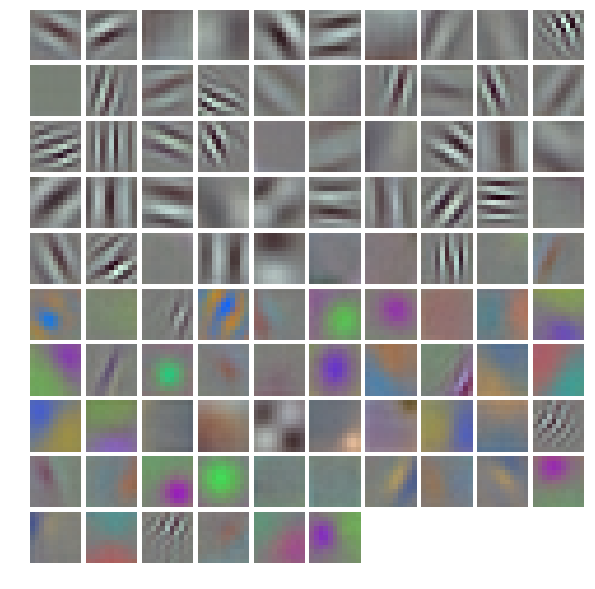

In [15]:
# the first layer filters, conv1 - the parameters are a list of [weights, biases]
filters = net.params['conv1'][0].data
vis_square(filters.transpose(0, 2, 3, 1))

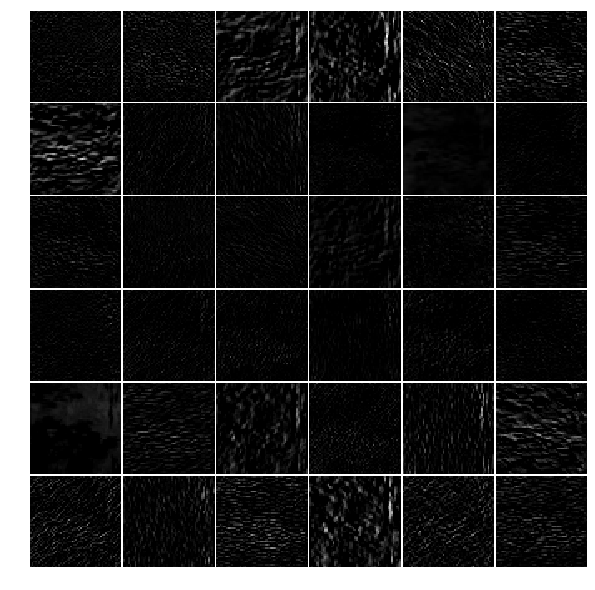

In [16]:
#The first layer output, conv1 (rectified responses of the filters above, first 36 only)
feat = net.blobs['conv1'].data[0,:36]
vis_square(feat)

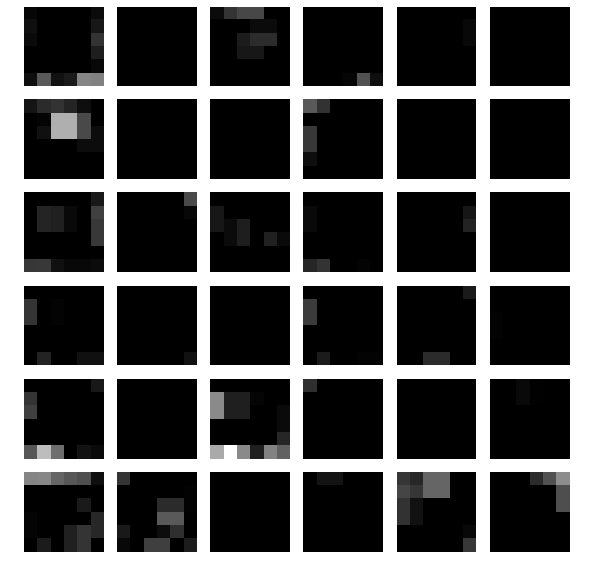

In [17]:
#The fifth layer after pooling, pool5(first 36 only))
feat = net.blobs['pool5'].data[0,:36]
vis_square(feat)

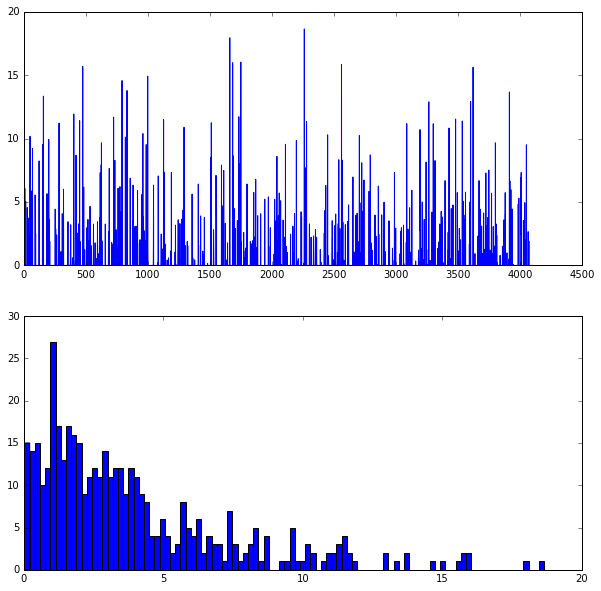

In [18]:
#The first fully connected layer, fc6 (rectified) - the output values and the histogram of the positive values
feat = net.blobs['fc6'].data[0]
plt.subplot(2, 1, 1)
plt.plot(feat.flat)
plt.subplot(2, 1, 2)
_ = plt.hist(feat.flat[feat.flat > 0], bins=100)

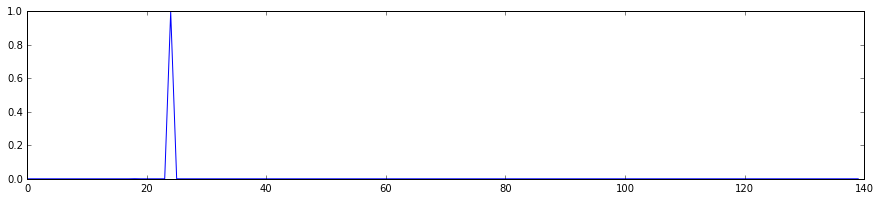

In [19]:
#Hist of the final probability output('prob' layer) distribution
feat = net.blobs['prob'].data[0]
plt.figure(figsize=(15, 3))
plt.plot(feat.flat)